In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
%matplotlib inline

from mesa import Agent,Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
%matplotlib inline

from mesa import Agent,Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
class Firefly(Agent):
    def __init__(self,unique_id,pos,model):
        super().__init__(unique_id,model)
        self.pos = pos
        self.clock = self.random.randint(1,self.model.cycle_length)
        self.flashes_seen = 3  # track number of flashes seen in a tick

    def is_flashing(self):
        return self.clock <= self.model.flash_length

    def step(self):
        # self.clock = self.clock+1
        self._next = self.clock+1
        if self._next > self.model.cycle_length:
            self._next = 1

        if not self.is_flashing():
            neighbours = self.model.grid.get_neighbors(self.pos,True)
            for neighbour in neighbours:
                if neighbour.is_flashing():
                    self.flashes_seen += 1
                    self._next = self.model.flash_length + 1
                    if self.flashes_seen >= self.model.flashes_to_reset:
                        self.clock = 1  # reset clock if enough flashes seen
                        self.flashes_seen = 0  # reset flashes seen count
                        return
            self.flashes_seen = 0  # reset flashes seen count if no flashes seen in tick
        else:
            neighbours_flashing = self.model.grid.get_neighbors(self.pos,True)
            for neighbour in neighbours_flashing:
                if neighbour.is_flashing():
                    self.flashes_seen += 1
                if self.flashes_seen >= self.model.flashes_to_reset:
                    self._next = self.model.flash_length + 1
            self.flashes_seen = 0

    def advance(self):
        self.clock = self._next
        self.move()

    def move(self):
        next_moves = self.model.grid.get_neighborhood(self.pos,True,True)
        next_move = self.random.choice(next_moves)
        self.model.grid.move_agent(self,next_move)

class FireflyWorld(Model):
    def __init__(self, height=30, width=30, cycle_length=10, flash_length=1, fly_number = 200, flashes_to_reset = 3):
        super().__init__()
        self.cycle_length = cycle_length
        self.flash_length = flash_length
        self.fly_number = fly_number
        self.flashes_to_reset = flashes_to_reset

        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(height,width, torus=True)
        self.dc = DataCollector({"Flashing":lambda m: self.count_flashing()})

        for i in range(self.fly_number):
            pos = (self.random.randint(0,width-1),
                   self.random.randint(0,height-1))
            f = Firefly(self.next_id(),pos,self)
            self.grid.place_agent(f,pos)
            self.schedule.add(f)

        self.running = True

    def step(self):
        self.schedule.step()
        self.dc.collect(self)

        if self.schedule.time > 1500:
            self.running = False

    def count_flashing(self):
        count = 0
        for f in self.schedule.agents:
            if f.is_flashing():
                count+=1
        return count

In [23]:
ff = FireflyWorld(30,30,30,1)

In [24]:
ff.run_model()

In [25]:
result = ff.dc.get_model_vars_dataframe()

In [26]:
result

,Flashing
0,3
1,10
2,6
3,4
4,7
...,...
1496,0
1497,0
1498,0
1499,0


In [27]:
result["time"] = np.linspace(0,len(result) - 1, len(result))

In [28]:
result

,Flashing,time
0,3,0.0
1,10,1.0
2,6,2.0
3,4,3.0
4,7,4.0
...,...,...
1496,0,1496.0
1497,0,1497.0
1498,0,1498.0
1499,0,1499.0


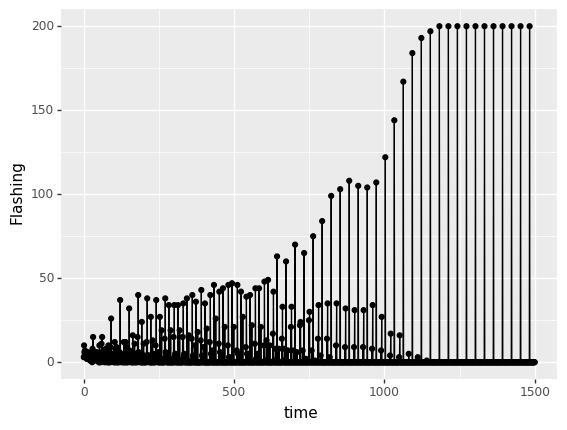

<ggplot: (139401684842)>

In [29]:
ggplot(result,aes(x="time",y="Flashing"))\
+geom_line() + geom_point()

In [20]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserParam, Slider
from Enviroment import FireflyWorld
from Agent import Firefly


def firefly_portrayal(agent):
    if agent is None:
        return

    portrayal = {}
    if isinstance(agent, Firefly):
        portrayal["Shape"] = "circle"
        portrayal["r"] = 0.5
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 0

        if agent.is_flashing():
            portrayal["Color"] = "orange"
        else:
            portrayal["Color"] = "grey"
    else:
        portrayal["Shape"] = "rect"
        portrayal["w"] = 1
        portrayal["h"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 0
        portrayal["Color"] = "#FFFFFF"
    return portrayal


canvas_element = CanvasGrid(firefly_portrayal, 30, 30, 500, 500)

model_params = {
    "height": 30,
    "width": 30,
    "cycle_length": Slider("Cycle length", 1, 10, 20, 1),
    "flash_length": Slider("Flash duration", 1, 1, 5, 1),
    "fly_number": Slider("NUmber of FLy", 100, 100, 2000, 100)
}

server = ModularServer(FireflyWorld,
                       [canvas_element],
                       "Firefly Model",
                       model_params)

server.port = 8521
server.launch()


TypeError: __init__() got an unexpected keyword argument 'fly_number'

Video to fix: https://www.youtube.com/watch?v=MpyA_RKZ6A8&list=PLBnmWnLGF3aaNXgdunV3yiNchqfEEJfHP&index=4